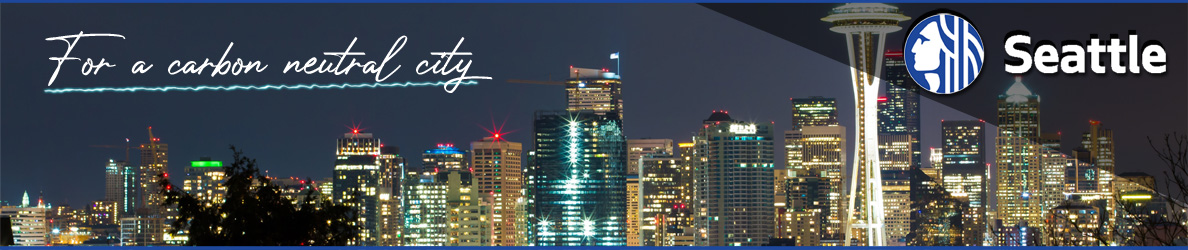

# <font color="#1d479b">Contexte</font>

Pour atteindre l'objectif de **ville neutre en émissions de carbone en 2050**, la ville de **Seattle** s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous devons tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

<hr width="50%" align="center"/>

La première partie nous a permis de réaliser un nettoyage des fichiers et une courte analyse exploratoire *([Seattle building energy cleaning - Kaggle Notebook](https://www.kaggle.com/michaelfumery/seattle-building-energy-cleaning))*.      
Dans cette seconde partie, nous allons réaliser les diverses **modélisations grâce à des approches linéaires et non-linéaire afin de prédire les émissions de CO2 et les consommations d'énergie des bâtiments**.

# <font color="#1d479b">Sommaire</font>
1. [Preprocessing](#section_1)     
    1.1. [Encodage et standardisation](#section_1_1)     
    1.2. [Préparation des jeux d'entrainement et de test](#section_1_2)     
2. [Modèle Baseline : Régression linéaire multivariée](#section_2)     
3. [Modèle linéaires : ElasticNet et SVR](#section_3)     
    3.1. [Modèle ElasticNet](#section_3_1)     
    3.2. [Modèle Support Vector Regression (SVR)](#section_3_2)     
4. [Modèle non-linéaires : XGBoost et RandomForestRegressor](#section_4)     
    4.1. [Modèle RandomForestRegressor](#section_4_1)     
    4.2. [Modèle XGBoost *(eXtreme Gradient Boosting)*](#section_4_2)          
5. [Sélection des meilleurs modèles](#section_5)     
    5.1. [Modèle de prédiction des émissions de CO2](#section_5_1)     
    5.2. [Modèle de prédiction des consommations d'énergie](#section_5_2)     
6. [Test des modèles sélectionnés](#section_6)    
    6.1. [Prédiction des émissions de CO2](#section_6_1)     
    6.2. [Prédiction des consommation d'énergie](#section_6_2)     
7. [Influence du score ENERGY STAR](#section_7)

## <font color="#337da4" id="section_1">1. Preprocessing</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style("whitegrid")
sns.color_palette("crest", as_cmap=True)
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/buildingenergycleaned/building-energy-cleaned.csv
/kaggle/input/sea-building-energy-benchmarking/2016-building-energy-benchmarking.csv
/kaggle/input/sea-building-energy-benchmarking/socrata_metadata_2016-building-energy-benchmarking.json
/kaggle/input/sea-building-energy-benchmarking/2015-building-energy-benchmarking.csv
/kaggle/input/sea-building-energy-benchmarking/socrata_metadata_2015-building-energy-benchmarking.json


Comme nous l'avons vu dans l'analyse exploratoire, un modèle simple de **régression linéaire multivarié** ne pourrait pas répondre totalement à notre problème de prédiction. Nous allons donc utiliser ce premier modèle comme baseline et tester les métriques principales : **R²** et **MAE**.

In [2]:
data = pd.read_csv("../input/buildingenergycleaned/building-energy-cleaned.csv")
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,State,ZipCode,Neighborhood,LargestPropertyUseType,...,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
0,325,2015,NonResidential,Retail Store,WESTLAKE MALL RETAIL PORTION,400 PINE ST,WA,98101.0,DOWNTOWN,Unknown,...,9899135.0,0.0,69.01,26,1,1.00000,0.00000,111077.0,27769.250,0.439292
1,400,2015,NonResidential,Small- and Mid-Sized Office,GALLAND & SENECA BUILDINGS,1201 2ND AVE,WA,98101.0,DOWNTOWN,Office,...,6488262.0,37893.0,47.24,109,1,0.73651,0.26349,98370.0,16395.000,0.236408
2,442,2015,NonResidential,Large Office,KING BROADCASTING,333 DEXTER AVE N,WA,98109.0,LAKE UNION,Office,...,16760914.0,0.0,116.84,68,5,0.80466,0.19534,193788.0,48447.000,1.171413
3,499,2015,NonResidential,Small- and Mid-Sized Office,ASIAN COUNSELING and REFERRAL SERVICE BUILDING,3639 MARTIN LUTHER KING JR WAY S,WA,98144.0,GREATER DUWAMISH,Office,...,2234200.0,2242889.0,134.69,7,2,0.72049,0.27951,76598.0,25532.667,2.924194
4,559,2015,NonResidential,Large Office,YALE & THOMAS,325 EASTLAKE AVE E,WA,98109.0,LAKE UNION,Office,...,9657951.0,3004906.0,226.92,34,2,1.00000,0.00000,186971.0,46742.750,1.044201


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   OSEBuildingID             1575 non-null   int64  
 1   DataYear                  1575 non-null   int64  
 2   BuildingType              1575 non-null   object 
 3   PrimaryPropertyType       1575 non-null   object 
 4   PropertyName              1575 non-null   object 
 5   Address                   1575 non-null   object 
 6   State                     1575 non-null   object 
 7   ZipCode                   1562 non-null   float64
 8   Neighborhood              1575 non-null   object 
 9   LargestPropertyUseType    1575 non-null   object 
 10  YearsENERGYSTARCertified  98 non-null     object 
 11  NumberofBuildings         1575 non-null   float64
 12  NumberofFloors            1575 non-null   float64
 13  PropertyGFATotal          1575 non-null   float64
 14  ENERGYST

In [4]:
data.describe()

,OSEBuildingID,DataYear,ZipCode,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
count,1575.000000,1575.000000,1562.000000,1575.000000,1575.000000,1.575000e+03,1042.000000,1.575000e+03,1.575000e+03,1.575000e+03,1.575000e+03,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000,1.575000e+03,1575.000,1575.000000
mean,16487.760000,2015.982857,98116.768886,1.159048,4.256508,1.209164e+05,63.021593,8.858683e+06,5.473360e+05,6.149722e+06,2.041839e+06,193.561146,54.495238,1.948571,0.933095,0.066905,1.115253e+05,inf,2.711239
std,13812.544249,0.129845,18.623406,2.917209,6.734122,3.041269e+05,28.431588,3.117209e+07,5.549832e+06,2.140776e+07,9.747677e+06,772.656653,32.981972,1.243237,0.143032,0.143032,1.911740e+05,NaN,2.188842
min,1.000000,2015.000000,98006.000000,0.500000,0.000000,1.128500e+04,1.000000,5.526710e+04,0.000000e+00,7.000000e+00,0.000000e+00,0.385000,1.000000,1.000000,-0.251160,-0.000010,7.166667e+03,221.697,0.021130
25%,603.500000,2016.000000,98104.000000,1.000000,1.000000,2.881400e+04,43.625000,1.238181e+06,0.000000e+00,7.401415e+05,0.000000e+00,20.610000,27.000000,1.000000,1.000000,0.000000,2.880000e+04,12960.000,0.835378
50%,21182.000000,2016.000000,98109.000000,1.000000,2.000000,4.817900e+04,69.500000,2.679420e+06,0.000000e+00,1.756366e+06,4.821830e+05,50.935000,51.000000,2.000000,1.000000,0.000000,4.817900e+04,22500.000,2.081436
75%,24614.000000,2016.000000,98125.000000,1.000000,4.000000,1.079375e+05,87.000000,7.310176e+06,0.000000e+00,5.254096e+06,1.525438e+06,145.440000,87.000000,2.000000,1.000000,0.000000,1.061235e+05,37485.125,4.091084
max,50226.000000,2016.000000,98199.000000,111.000000,99.000000,9.320156e+06,100.000000,8.739237e+08,1.314066e+08,6.570744e+08,2.979090e+08,16870.980000,116.000000,13.000000,1.000010,1.251160,2.761918e+06,inf,8.843544


Dans cette description, on remarque des données avec des **valeurs infinies** *(16 entrées)*. Nous allons regarder de plus prêt ces données et les corriger :

In [5]:
data[(data.GFAPerBuilding == np.inf) | (data.GFAPerFloor == np.inf)].head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,State,ZipCode,Neighborhood,LargestPropertyUseType,...,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
156,267,2016,NonResidential,Hotel,Grand Hyatt Seattle,721 Pine St,WA,98101.0,DOWNTOWN,Hotel,...,39516051.5,24913925.5,1598.655,17,5,1.00000,0.00000,934292.0,inf,0.455683
455,656,2016,NonResidential,Medical Office,Arnold Pavilion,1221 Madison Street,WA,98104.0,EAST,Medical Office,...,12268893.0,0.0,648.285,12,1,1.00000,0.00000,225982.0,inf,0.491603
456,657,2016,NonResidential,Mixed Use Property,2200 Westlake - SEDO,2200 Westlake Ave.,WA,98121.0,DOWNTOWN,Parking,...,29657760.5,14535043.5,978.705,10,7,1.00000,0.00000,1032814.0,inf,0.838548
526,758,2016,NonResidential,Other,Pacific Place,600 Pine Street,WA,98101.0,DOWNTOWN,Other - Mall,...,47328085.0,0.0,329.940,17,4,0.76783,0.23217,947987.0,inf,0.485479
1019,23311,2016,NonResidential,Medical Office,HART First Hill LLC,1124 Columbia Street,WA,98104.0,EAST,Medical Office,...,11948708.5,0.0,1112.250,71,2,1.00000,0.00000,274568.0,inf,0.424374


In [6]:
data['GFAPerBuilding'] = np.where(((data.GFAPerBuilding == np.inf) & (data.NumberofBuildings == 0)),0, data.GFAPerBuilding)
data['GFAPerFloor'] = np.where(((data.GFAPerFloor == np.inf) & (data.NumberofFloors == 0)),0, data.GFAPerFloor)

Comme nous l'avons remarqué dans le [Notebook de nettoyage](https://www.kaggle.com/michaelfumery/seattle-building-energy-cleaning), les Campus sont très consommateurs en energie. Nous allons vérifier la distribution des consommations en fonction des surfaces totales au sol par catégorie de bâtiment. D'éventuels valeurs hors-normes pourraient poser des problèmes pour les modélisations :

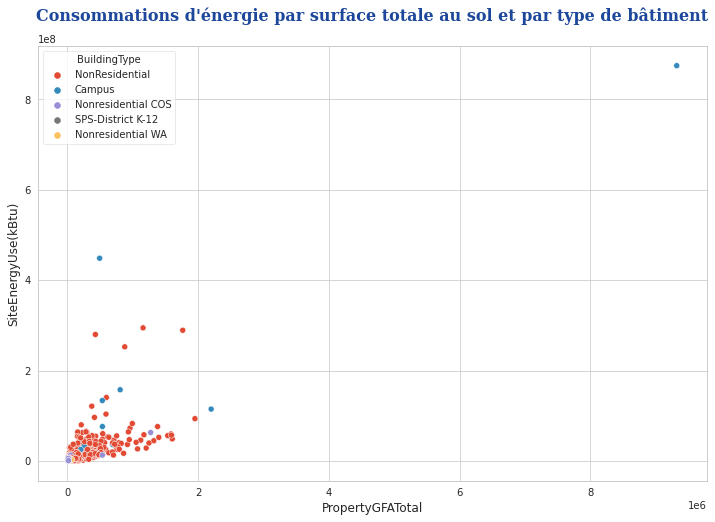

In [7]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = data, x='PropertyGFATotal', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Consommations d'énergie par surface totale au sol et par type de bâtiment\n", 
          fontdict=font_title, fontsize=16)
plt.show()

Un bâtiment de type campus est très supérieur aux autres données. Il ne s'agit sans doute pas d'une valeur abérrante mais d'une **valeur atypique** qui est très isolée. Nous allons ici la supprimer de nos données sources.

In [8]:
data[data['SiteEnergyUse(kBtu)']>8*10**8]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,State,ZipCode,Neighborhood,LargestPropertyUseType,...,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
1537,49967,2016,Campus,University,University of Washington - Seattle Campus,NE 45th St & Brooklyn Ave,WA,98105.0,NORTHEAST,College/University,...,657074389.0,0.0,11140.56,116,1,1.0,0.0,83965.369,0.0,3.612662


In [9]:
data = data[data['SiteEnergyUse(kBtu)']<8*10**8]

Nous allons **regrouper les données d'identification des bâtiments** afin qu'elles ne perturbent pas nos modélisations mais restent utilisables.

In [10]:
identification_features = ['OSEBuildingID', 'PropertyName', 'Address', 'ZipCode']
data_identification = data[identification_features]
data.drop(identification_features, axis=1, inplace = True)

Le but de notre programme est de supprimer les relevés couteux pour les années à venir. **Nous allons donc exclure toutes les données de relève de notre dataset**.

In [11]:
data_filter = data.drop(['SteamUse(kBtu)','Electricity(kBtu)',
                         'NaturalGas(kBtu)'], axis=1)

### <font color="#2cb7b0" id="section_1_1">1.1. Encodage et standardisation</font>

Nous allons séparer les données numériques et les données catégorielles de notre dataset :

In [12]:
numerical_features = data_filter.select_dtypes(include=['int64','float64'])
categorical_features = data_filter.select_dtypes(exclude=['int64','float64']) 

Pour les données catégorielles, nous allons devoir encoder les valeurs. Nous allons donc supprimer les variables qui n'apporteront rien à notre modèle *(les constantes par exemple)* et séparer les variables pouvant être encodées en OneHot des autres.

In [13]:
categorical_features.nunique()

BuildingType                 5
PrimaryPropertyType         22
State                        1
Neighborhood                19
LargestPropertyUseType      57
YearsENERGYSTARCertified    64
dtype: int64

In [14]:
categorical_features = categorical_features.drop(['State','YearsENERGYSTARCertified'], axis=1)

Pour toutes ces variables, nous utiliserons la méthode *TagetEncoder* de la librairie Category_Encoders que nous intégrerons dans un pipeline Sklearn.     
Cet encodeur réalise 2 principales étapes :
1. Groupe les données par chaque catégorie et compte de nombre d'occurrences de chaque cible.
2. Calcul de la probabilité que chaque cible se produise pour chaque groupe spécifique.

Regardons maintenant les données numériques :

In [15]:
list(numerical_features.columns)

['DataYear',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'BuildingAge',
 'TotalUseTypeNumber',
 'GFABuildingRate',
 'GFAParkingRate',
 'GFAPerBuilding',
 'GFAPerFloor',
 'harvesine_distance']

La date de relevé ne nous sera pas utile ici, nous la supprimerons du jeu de données. `ENERGYSTARScore` est insuffisement complété. Nous allons l'écarter du dataset mais nous la conservons pour **vérifier ensuite si cette variable a un impact sur la qualité de prédiction**.

In [16]:
energystar_score = numerical_features['ENERGYSTARScore']
numerical_features = numerical_features.drop(['ENERGYSTARScore','DataYear'], axis=1)

Les données numériques doivent être standardisées pour entrer dans nos modèles de prédiction. Nous réaliserons un **centrage-réduction** via la méthode `StandardScaler` de Scikit-Learn.

In [17]:
data_filter = pd.concat([categorical_features, numerical_features], axis=1)

#### Préparation du Preprocessor

In [18]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, RobustScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer

target_features = ['BuildingType','PrimaryPropertyType','Neighborhood','LargestPropertyUseType']
target_transformer = TargetEncoder()

numeric_features = ['harvesine_distance','NumberofBuildings','NumberofFloors',
                    'PropertyGFATotal','BuildingAge','TotalUseTypeNumber',
                    'GFABuildingRate','GFAParkingRate','GFAPerBuilding','GFAPerFloor']
numeric_transformer = RobustScaler(unit_variance=True)

preprocessor = ColumnTransformer(transformers=[
    ('target', target_transformer, target_features),
    ('numeric', numeric_transformer, numeric_features)
])

In [19]:
import warnings
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
        
    ------
    Code from :
        https://johaupt.github.io/
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [f for f in column]

        return [f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        feature_names.extend(get_names(trans))
    
    return feature_names

### <font color="#2cb7b0" id="section_1_2">1.2. Préparation des jeux d'entrainement et de test</font>

Afin de **tester notre meilleur modèle** sur des données "inconnues", nous allons mettre de côté une partie des données initiales qui ne seront pas inclusent dans les modèles intermédiaires. Nous allons donc spliter nos données pour obtenir un jeu d'entrainement et un jeu de test *(20% des données)*

In [20]:
from sklearn.model_selection import train_test_split

X = data_filter.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
Y = data_filter[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 1259 lignes,
Test: 315 lignes.



Concernant nos variables à prédire, nous allons regarder l'**impact du passage à l'échelle logarithmique sur les distribution** :

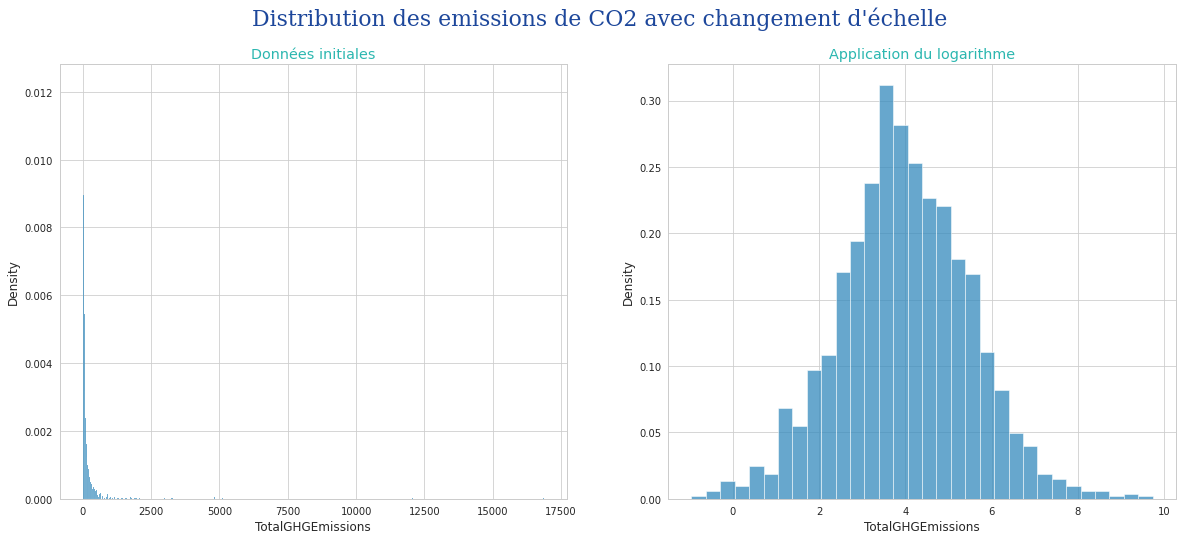

In [21]:
from sklearn.preprocessing import FunctionTransformer

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y, x='TotalGHGEmissions', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=Y_log, x='TotalGHGEmissions', stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0')
plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle", fontdict=font_title, fontsize=22)
plt.show()

En passant les données à l'échelle logarithmique, nous obtenons une distribution normale des données à prédire. Nous allons donc appliquer cette transformation dans notre pipeline grâce à la fonction `TransformedTargetRegressor` de la librairie Sklearn.

La fonction inverse (exp) sera donc passée dans les prédictions.

## <font color="#337da4" id="section_2">2. Modèle Baseline : Régression linéaire multivariée</font>

A présent, nous allons créer un modèle baseline pour évaluer les performances de nos futurs modèles et vérifier qu'ils améliore les prédictions. Pour cette baseline, nous utiliserons une **régression linéaire multivariée**.

In [22]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import set_config
set_config(display='diagram')


param_mlr = {"regressor__fit_intercept": [True, False],
             "regressor__normalize": [True, False]}

mlr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_mlr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=LinearRegression(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_mlr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

Nous allons calculer 2 principales métriques pour évaluer nos modèles :
- **MAE** : Mean Absolute Error.
- **R²** : Coeficient de détermination, carré du coefiscient de corrélation linéaire.

In [23]:
#Retour des meilleurs scores NMAE et R2
#Stockage du dataframe de resultats du modèle
def model_scores(pip,step):
    df_results = pd.DataFrame.from_dict(pip.named_steps[step].cv_results_) \
                    .sort_values('rank_test_neg_mean_absolute_error')
    best_nmae = pip.named_steps[step].best_score_
    best_r2 = np.mean(df_results[df_results.rank_test_r2 == 1]['mean_test_r2'])
    best_params = pip.named_steps[step].best_params_
    training_time = round((np.mean(df_results.mean_fit_time)*X_train.shape[0]),2)
    print("Meilleur score MAE : {}\nMeilleur Score R2 : {}\nMeilleurs paramètres : {}\nTemps moyen d'entrainement : {}s"\
         .format(round(best_nmae,3), round(best_r2,3), best_params, training_time))
    return df_results

On affiche les **scores de la GridSearch avec validation croisée** pour la variable `TotalGHGEmissions` :

In [24]:
#Entrainement sur les 2 variables à expliquer :
GHG_mlr_model = mlr_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
GHG_mlr_results = model_scores(GHG_mlr_model, 'grid_search_mlr')

Meilleur score MAE : -516.022
Meilleur Score R2 : -126.213
Meilleurs paramètres : {'regressor__fit_intercept': True, 'regressor__normalize': False}
Temps moyen d'entrainement : 4.06s


et les scores pour la variable `SiteEnergyUse(kBtu)` :

In [25]:
SEU_mlr_model = mlr_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
SEU_mlr_results = model_scores(SEU_mlr_model, 'grid_search_mlr')

Meilleur score MAE : -15953097.643
Meilleur Score R2 : -82.719
Meilleurs paramètres : {'regressor__fit_intercept': True, 'regressor__normalize': False}
Temps moyen d'entrainement : 2.91s


Tous les résultats des GridSearchCV sont stockés dans un DataFrame pour chaque variable à prédire :

In [26]:
GHG_mlr_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__fit_intercept,param_regressor__normalize,params,split0_test_r2,split1_test_r2,split2_test_r2,...,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
1,0.002717,0.000200,0.001193,0.000167,True,False,"{'regressor__fit_intercept': True, 'regressor_...",0.060018,-594.854989,-8.212434,...,-516.021851,529.467124,1,-317.261754,-210.103083,-301.473337,-256.745882,-320.049555,-281.126722,42.127176
0,0.005524,0.005169,0.001219,0.000162,True,True,"{'regressor__fit_intercept': True, 'regressor_...",0.060018,-594.854989,-8.212434,...,-516.021851,529.467124,2,-317.261754,-210.103083,-301.473337,-256.745882,-320.049555,-281.126722,42.127176
2,0.002459,0.000151,0.001169,0.000156,False,True,"{'regressor__fit_intercept': False, 'regressor...",-0.978115,-164349.016027,-189.428119,...,-6556.226577,8367.931746,3,-1110.294680,-940.495133,-1247.899217,-1060.478711,-1319.418007,-1135.717150,134.721625
3,0.002213,0.000552,0.001098,0.000362,False,False,"{'regressor__fit_intercept': False, 'regressor...",-0.978115,-164349.016027,-189.428119,...,-6556.226577,8367.931746,3,-1110.294680,-940.495133,-1247.899217,-1060.478711,-1319.418007,-1135.717150,134.721625


In [27]:
SEU_mlr_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('target', TargetEncoder(),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType']),
                                                 ('numeric',
                                                  RobustScaler(unit_variance=True),
                                                  ['harvesine_distance',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   'TotalUseTypeNumber',
                                                   'GFABuildingRate',
                                                   'GFAP...
                                                   'GFAPerFloor'])])),
                ('grid_search_mlr',
                 GridSearchCV(cv=5,
                              estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=LinearRegression()),
                              n_jobs=-1,
                              param_grid={'regressor__fit_intercept': [True,
                                                                       False],
                                          'regressor__normalize': [True,
                                                                   False]},
                              refit='neg_mean_absolute_error',
                              return_train_score=True,
                              scoring=('r2', 'neg_mean_absolute_error')))])

Nous avons à présent nos métriques de départ obtenues avec notre modèle de régression linéaire multivarié servant de baseline. Nous allons réaliser nos premières modélisations en utilisant des modèles linéaires.

## <font color="#337da4" id="section_3">3. Modèle linéaires : ElasticNet et SVR</font>

### <font color="#2cb7b0" id="section_3_1">3.1. Modèle ElasticNet</font>

<details>
<summary><font color="blue"><b>Explication du modèle :</b></font></summary>

La régression linéaire est un modèle simple tente de minimiser la somme des erreurs au carré. 
L'erreur dans ce cas est la différence entre la donnée réelle et sa valeur prédite. 
Pour produire un modèle plus précis de données complexes, nous pouvons ajouter un <b>terme de pénalité à l'équation OLS</b>.
Une pénalité ajoute un <b>biais</b> sur certaines valeurs. 

Celles-ci sont appelées <b>régularisation L1 <em>(régression Lasso)</em></b> et <b>régression L2 <em>(régression Ridge)</em></b>. Le meilleur modèle que nous pouvons espérer proposer minimise à la fois le biais et la variance.

<h5>Régression Ridge</h5>
La régression Ridge utilise une régularisation L2 qui ajoute la pénalité suivante à l'équation OLS : $\large + \lambda \sum_{j=0}^{p} w^0_j$

Le terme L2 est égal au carré de la magnitude des coefficients. Dans ce cas, si lambda ($\lambda$) est égal à zéro, l'équation est l'OLS de base mais si elle est supérieure à zéro, nous ajoutons une contrainte aux coefficients. <b>La régression Ridge diminue la complexité d'un modèle mais ne réduit pas le nombre de variables, elle réduit simplement leur effet</b>.
    
<h5>Régression Lasso</h5>
La régression Lasso utilise le terme de pénalité L1 et représente le Least Absolute Shrinkage et l'opérateur de sélection. La pénalité appliquée est égale à la valeur absolue de la magnitude des coefficients : $\large + \lambda \sum_{j=0}^{p} |w_j|$
    
    <b>L'application de ce terme peut éliminer complètement certaines variables</b> et donner un sous-ensemble de prédicteurs qui aident à atténuer la multi-colinéarité et la complexité du modèle.
    
<h5>Elastic Net</h5>
Elastic Net incorpore des pénalités de régularisation L1 et L2 :
$$\large \frac{\sum^{n}_{i=1}(y_i - x^i_j \hat{\beta})^2}{2n} + \lambda \left( \frac{1 - \alpha}{2} \sum^{m}_{j=1} \hat{\beta}^2_j + \alpha \sum^{m}_{j=1} |\hat{\beta}_j| \right) $$
    
En plus de définir et de choisir une valeur lambda, ElasticNet permet également d'ajuster le paramètre alpha où $\large \alpha = 0$ correspond à Ridge et $\large \alpha = 1$ à Lasso. On peut donc choisir une valeur alpha entre 0 et 1 pour optimiser ElasticNet <em>(cela réduira certains coefficients et en mettra d'autres à 0 pour une sélection parcimonieuse)</em>.
</details>


In [28]:
from sklearn.linear_model import ElasticNet

param_eNet = {"regressor__max_iter": [10, 100, 1000],
              "regressor__alpha": np.logspace(-4, 0, num=5),
              "regressor__l1_ratio": np.arange(0.0, 1.1, 0.1)}

eNet_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_enet', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=ElasticNet(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_eNet,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

In [29]:
GHG_eNet_model = eNet_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
GHG_eNet_results = model_scores(GHG_eNet_model, 'grid_search_enet')

Meilleur score MAE : -251.247
Meilleur Score R2 : -15.182
Meilleurs paramètres : {'regressor__alpha': 1.0, 'regressor__l1_ratio': 1.0, 'regressor__max_iter': 100}
Temps moyen d'entrainement : 7.1s


In [30]:
SEU_eNet_model = eNet_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
SEU_eNet_results = model_scores(SEU_eNet_model, 'grid_search_enet')

Meilleur score MAE : -12156855.334
Meilleur Score R2 : -41.785
Meilleurs paramètres : {'regressor__alpha': 1.0, 'regressor__l1_ratio': 1.0, 'regressor__max_iter': 1000}
Temps moyen d'entrainement : 9.24s


Suite à cette première modélisation par ElasticNet, **les métriques ne se sont que légérement améliorées pour les prédictions de la consommation d'énergie et des émissions de CO2**. Nous allons à présent tester un second modèle linéaire : SVR.

### <font color="#2cb7b0" id="section_3_2">3.2. Modèle Support Vector Regression (SVR)</font>

<details>
<summary><font color="blue"><b>Explication du modèle :</b></font></summary>
<h5>Les machines à vecteur de support</h5>
Dans le cas de données linéairement séparables, il existe généralement une infinité d'hyperplans séparateurs qui classifient correctement les données. Pour formaliser lequel parmi ces multiples hyperplans nous convient le mieux, nous allons définir la <b>marge d'un hyperplan</b> séparateur $\mathcal{H}$ comme deux fois la distance de $\mathcal{H}$ au point du jeu de données qui en est le plus proche.
    
Dans la plupart des cas, les données ne sont pas linéairement séparables. Il va donc falloir accepter de faire des erreurs, autrement dit que certains points de notre jeu d'entraînement se retrouvent du mauvais côté de la frontière de la zone d'indécision.
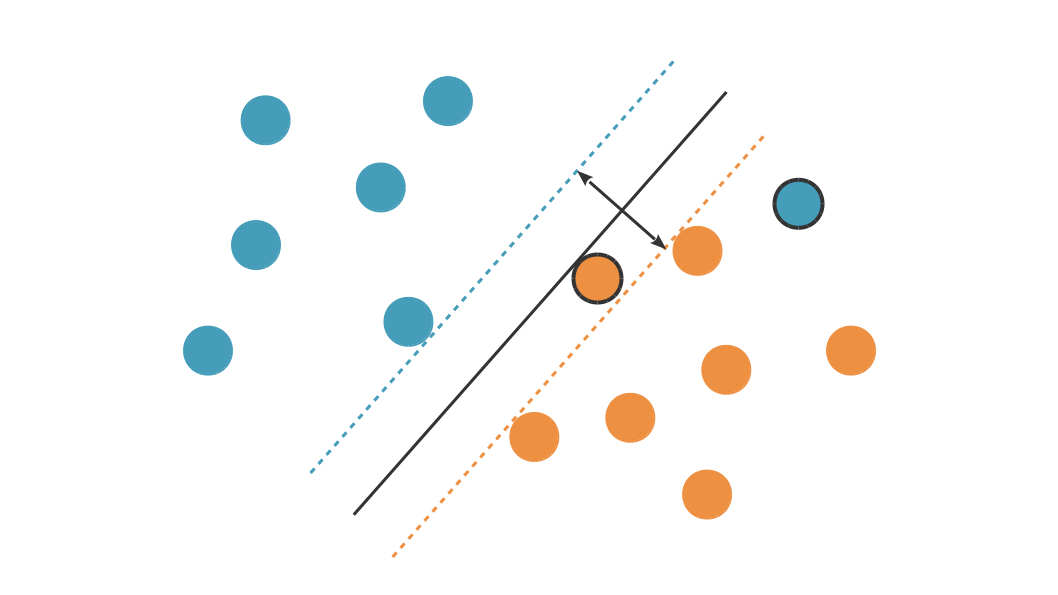
    
Plus la marge est grande, plus nous somme susceptibles d'avoir d'erreurs. Nous allons donc devoir <b>minimiser la marge et l'erreur simultanément</b> :

$$\large arg \, {\underset{w \in \mathbb{R}^{p}, b \in \mathbb{R}}{min}} \frac{1}{2} ||w||^2_2 + C \text{ erreur}$$

L'hyperparamètre $\large C$ sert à quantifier l'importance relative du terme d'erreur et du terme de marge.

Il s'agit donc bien d'une <b>régularisation ℓ2</b>, et le coefficient $\large C$ vaut $\large \frac{1}{2\lambda}$ par rapport à ce que nous avons pu écrire pour la régression Ridge.
    
<b>Les SVM peuvent aussi être utilisées pour des problèmes de régression <em>(SVR)</em></b> et on cherche toujours à minimiser $\large ||w||^2_2$ 
</details>

In [31]:
from sklearn.svm import LinearSVR

param_svr = {'regressor__C' : np.logspace(-4, 0, 5),
             'regressor__epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
             'regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
             'regressor__max_iter': [10, 100, 1000]}

svr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_svr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=LinearSVR(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_svr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [32]:
GHG_svr_model = svr_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
GHG_svr_results = model_scores(GHG_svr_model, 'grid_search_svr')

Meilleur score MAE : -4319.369
Meilleur Score R2 : -13086.477
Meilleurs paramètres : {'regressor__C': 0.0001, 'regressor__epsilon': 2, 'regressor__loss': 'epsilon_insensitive', 'regressor__max_iter': 1000}
Temps moyen d'entrainement : 53.92s


In [33]:
SEU_svr_model = svr_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
SEU_svr_results = model_scores(SEU_svr_model, 'grid_search_svr')

Meilleur score MAE : -8409760.881
Meilleur Score R2 : -0.169
Meilleurs paramètres : {'regressor__C': 0.0001, 'regressor__epsilon': 0, 'regressor__loss': 'epsilon_insensitive', 'regressor__max_iter': 10}
Temps moyen d'entrainement : 42.41s


Sur ce modèle **SVR linéaire, les métriques sont encore légérement améliorées** pour les 2 variables à prédire comparées au modèle ElasticNet.

Nous allons à présent nous pencher sur des modèles non-linéaires.

## <font color="#337da4" id="section_4">4. Modèle non-linéaires : XGBoost et RandomForestRegressor</font>

### <font color="#2cb7b0" id="section_4_1">4.1. Modèle RandomForestRegressor</font>

<details>
<summary><font color="blue"><b>Explication du modèle :</b></font></summary>
<h5>Random Forest</h5>
Les "forêts aléatoires" sont des algorithmes qui se basent sur l'assemblage d'arbre de décision indépendants.

Chaque arbre traitant seulement une partie du problème grâce à un double tirage aléatoire :
<ul>
    <li>Un tirage avec remplacement sur les individus : C'est le <b>tree bagging</b></li>
    <li>Un tirage aléatoire sur les variables : le <b>feature sampling</b></li>
</ul>

Au final, tous ces arbres de décisions indépendants sont assemblés. La prédiction faite par le random forest pour des données inconnues est alors la moyenne de tous les arbres dans le cas de la régression.
</details>

In [34]:
from sklearn.ensemble import RandomForestRegressor

param_rfr = {'regressor__max_features' : ['sqrt', 'log2'],
             'regressor__max_depth': [5, 15, 25, 50],
             'regressor__min_samples_split': [2, 5, 10],
             'regressor__bootstrap' : [True, False],
             'regressor__min_samples_leaf': [1,2,5,10]}

rfr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=RandomForestRegressor(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_rfr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [35]:
GHG_rfr_model = rfr_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
GHG_rfr_results = model_scores(GHG_rfr_model, 'grid_search_rfr')

Meilleur score MAE : -116.387
Meilleur Score R2 : 0.558
Meilleurs paramètres : {'regressor__bootstrap': False, 'regressor__max_depth': 50, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Temps moyen d'entrainement : 439.49s


In [36]:
SEU_rfr_model = rfr_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
SEU_rfr_results = model_scores(SEU_rfr_model, 'grid_search_rfr')

Meilleur score MAE : -4016517.949
Meilleur Score R2 : 0.578
Meilleurs paramètres : {'regressor__bootstrap': False, 'regressor__max_depth': 50, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Temps moyen d'entrainement : 439.15s


### <font color="#2cb7b0" id="section_4_2">4.2. Modèle XGBoost *(eXtreme Gradient Boosting)*</font>

<details>
<summary><font color="blue"><b>Explication du modèle :</b></font></summary>
<h5>XGBoost</h5>
Comme son nom l'indique, ce modèle est un algorithme de gradient boosting. Ce boosting consiste à assembler plusieurs algorithmes ayant une performance peu élevée pour en créer un beaucoup plus efficace.

Dans le cadre de la régression, les variables à prédire vont être estimées avec un premier modèle, puis les résidus de ce modèle deviendront les variables cible du second modèle, et ainsi de suite.
    
Pour pouvoir prédire un output en fonction d’un input dont on ne connait pas la variable cible, il faut prédire le résidu de chaque modèle et ensuite en faire la somme.
    
Pour l'agorithme XGBoost, réalisé une GridSearch en "brute", en testant toutes les combinaisons est très long et très couteux en temps de calcul. Pour palier à ce problème, nous allons ici utiliser une grille de recherche aléatoire.
</details>

In [37]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_xgb = {'regressor__learning_rate' : [0.001, 0.01, 0.1, 0.2, 0,3],
             'regressor__gamma': [0, 0.25, 0.5, 1.0],
             'regressor__max_depth': [6, 10, 15, 20],
             'regressor__min_child_weight' : [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
             'regressor__n_estimators': [25, 50, 100, 500, 1000]}

xgb_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_xgb', RandomizedSearchCV(
                            TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor(tree_method='gpu_hist'), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_distributions=param_xgb,
                            n_iter=20,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [38]:
GHG_xgb_model = xgb_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
GHG_xgb_results = model_scores(GHG_xgb_model, 'grid_search_xgb')

Meilleur score MAE : -113.1
Meilleur Score R2 : 0.568
Meilleurs paramètres : {'regressor__n_estimators': 100, 'regressor__min_child_weight': 3.0, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.25}
Temps moyen d'entrainement : 3388.09s


In [39]:
SEU_xgb_model = xgb_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
SEU_xgb_results = model_scores(SEU_xgb_model, 'grid_search_xgb')

Meilleur score MAE : -3917323.769
Meilleur Score R2 : 0.614
Meilleurs paramètres : {'regressor__n_estimators': 100, 'regressor__min_child_weight': 7.0, 'regressor__max_depth': 10, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0}
Temps moyen d'entrainement : 2006.0s


Le modèle XGBoost non-linéaire a des niveaux de performances de prédiction sur les 2 variables quasi similaire au modèle RandomForestRegressor mais nous avons dû utiliser le GPU pour accélerer le temps de calcul.

## <font color="#337da4" id="section_5">5. Sélection des meilleurs modèles</font>

Sur les 4 modèles testés,les modèles linéaires retournent de moins bonnes métriques en général. Si nous prenons en considération le score MAE, qui aura du sens sur les modèles linéaires et non-linéaires, **les algorithmes XGBoost et RandomForestRegressor offrent des performances à peu près similaires pour la qualité des prédictions** mais les temps de calculs sont meilleurs sur le modèle RandomForestRegressor.

Nous allons donc regarder de plus près les résultats obtenus sur nos 2 variables à prédire avec les différents modèles :

### <font color="#2cb7b0" id="section_5_1">5.1. Modèle de prédiction des émissions de CO2</font>

In [40]:
metrics = ['mean_fit_time', 'mean_score_time',
           'mean_test_neg_mean_absolute_error',
           'mean_train_neg_mean_absolute_error']
GHG_compare_metrics = pd.concat([pd.DataFrame(GHG_rfr_results[metrics].mean(), columns=['RandomForest']),
           pd.DataFrame(GHG_xgb_results[metrics].mean(), columns=['XGBoost']),
           pd.DataFrame(GHG_svr_results[metrics].mean(), columns=['LinearSVR']),
           pd.DataFrame(GHG_eNet_results[metrics].mean(), columns=['ElasticNet']),
           pd.DataFrame(GHG_mlr_results[metrics].mean(), columns=['LinearRegression'])
          ], axis=1)
GHG_final_metrics_compare = pd.DataFrame(columns=metrics, 
                                     index=['RandomForest','XGBoost',
                                            'LinearSVR','ElasticNet',
                                            'LinearRegression'])
for m in metrics:
    GHG_final_metrics_compare[m] = GHG_compare_metrics.loc[m]

In [41]:
GHG_final_metrics_compare

,mean_fit_time,mean_score_time,mean_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error
RandomForest,0.349079,0.017092,-1.290455e+02,-9.566191e+01
XGBoost,2.691097,0.077380,-1.427453e+02,-1.087866e+02
LinearSVR,0.042826,0.001845,-2.707578e+58,-4.831859e+57
ElasticNet,0.005640,0.001594,-4.047644e+02,-2.928302e+02
LinearRegression,0.003228,0.001170,-3.536124e+03,-7.084219e+02


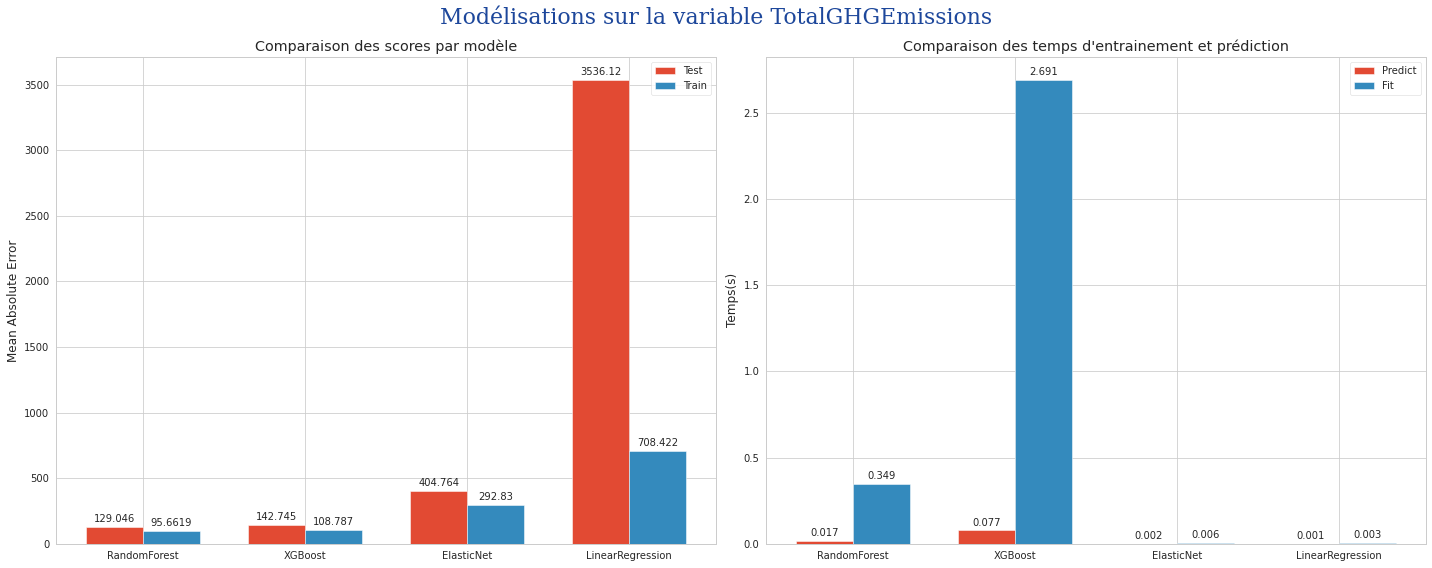

In [42]:
#On élimine le modèle SVR de cette représentation car hors normes
GHG_final_metrics_compare = GHG_final_metrics_compare[GHG_final_metrics_compare.index != 'LinearSVR']
x = np.arange(len(GHG_final_metrics_compare.index))
width = 0.35

fig, ax = plt.subplots(1,2,figsize=(20,8), sharey=False, sharex=False)

scores1 = ax[0].bar(x - width/2, -1*GHG_final_metrics_compare['mean_test_neg_mean_absolute_error'], width, label='Test')
scores2 = ax[0].bar(x + width/2, -1*GHG_final_metrics_compare['mean_train_neg_mean_absolute_error'], width, label='Train')
ax[0].set_ylabel('Mean Absolute Error')
ax[0].set_title('Comparaison des scores par modèle')
ax[0].set_xticks(x)
ax[0].set_xticklabels(GHG_final_metrics_compare.index)
ax[0].legend()
ax[0].bar_label(scores1, padding=3)
ax[0].bar_label(scores2, padding=3)

times1 = ax[1].bar(x - width/2, GHG_final_metrics_compare['mean_score_time'], width, label='Predict')
times2 = ax[1].bar(x + width/2, GHG_final_metrics_compare['mean_fit_time'], width, label='Fit')
ax[1].set_ylabel('Temps(s)')
ax[1].set_title("Comparaison des temps d'entrainement et prédiction")
ax[1].set_xticks(x)
ax[1].set_xticklabels(GHG_final_metrics_compare.index)
ax[1].legend()
ax[1].bar_label(times1, padding=3, fmt='%.3f')
ax[1].bar_label(times2, padding=3, fmt='%.3f')

plt.suptitle("Modélisations sur la variable TotalGHGEmissions", fontdict=font_title, fontsize=22)
fig.tight_layout()

plt.show()

Avec la projection graphique ci-dessus, on constate que le modèle RandomForestRegressor offre le meilleur compromis score / temps. Il est en effet meilleur en terme de score MAE et également bien plus rapide que le modèle XGBoost.

**<font color="green">Le modèle retenu pour la modélisation de la variable TotalGHGEmissions est donc le modèle RandomForestRegressor</font>**. Nous allons à présent visualiser l'impact des hyperparamètres de la GridSearch :

In [43]:
#Fonction d'affichage des scores de GridSearch pour chacun des paramètres
def plot_search_results(grid, title): 
       
    ## Résultats de la GridSearch
    results = grid.cv_results_
    means_test = results['mean_test_neg_mean_absolute_error']
    stds_test = results['std_test_neg_mean_absolute_error']
    means_train = results['mean_train_neg_mean_absolute_error']
    stds_train = results['std_train_neg_mean_absolute_error']

    ## Index de valeurs par hyper-paramètre
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    
    ## Plot des résultats
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Scores par paramètres pour la variable {}'.format(title), 
                 fontdict=font_title, fontsize=22)
    fig.text(0.04, 0.5, 'NEG MEAN ABSOLUTE ERROR SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test', color="#2cb7b0")
        ax[i].errorbar(x, y_2, e_2, linestyle='--', marker='o', label='train', color="#337da4")
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()
    
    print("\nRappel des meilleurs paramètres :\n{}".format(grid.best_params_))

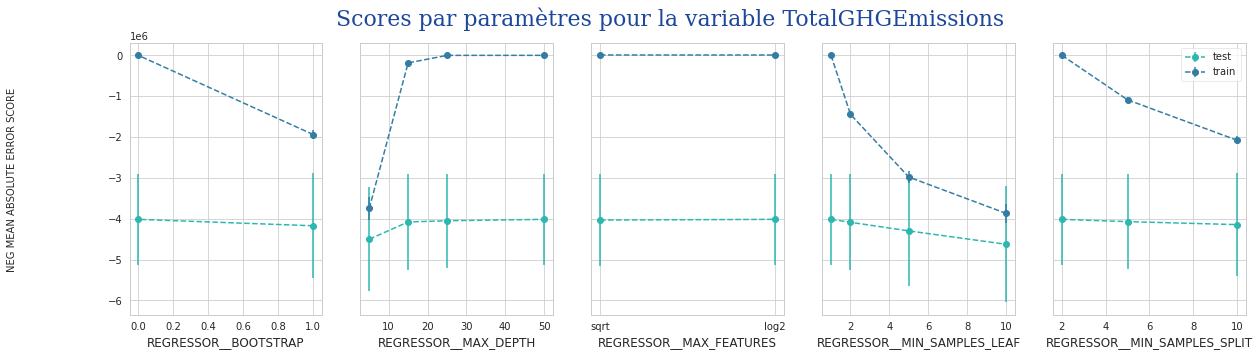


Rappel des meilleurs paramètres :
{'regressor__bootstrap': False, 'regressor__max_depth': 50, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}


In [44]:
plot_search_results(GHG_rfr_model.named_steps['grid_search_rfr'], title="TotalGHGEmissions")

Après avoir testé les premiers paramètres, nous avons à présent défini notre **modèle pour la prédiction des émissions de CO2**. Regardons à présent l'importance des variables dans notre modèle de forêts aléatoires :

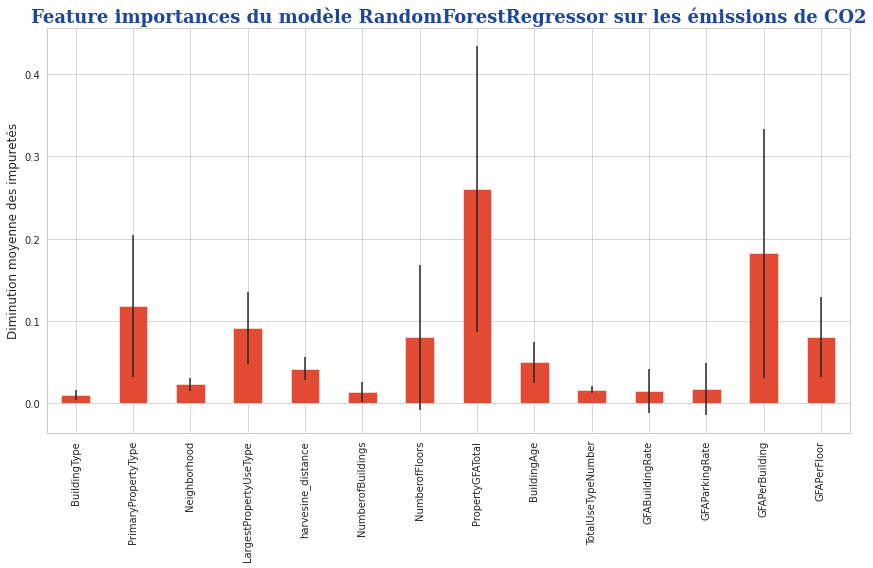

In [45]:
feature_importance = GHG_rfr_model.named_steps['grid_search_rfr'].best_estimator_.regressor_.feature_importances_ 
features_names = get_feature_names(GHG_rfr_model.named_steps['preprocessor'])
std = np.std([
    tree.feature_importances_ for tree in GHG_rfr_model.named_steps['grid_search_rfr'].best_estimator_.regressor_], axis=0)
df_feature_importance = pd.Series(feature_importance, index=features_names)

fig, ax = plt.subplots(figsize=(12,8))
df_feature_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances du modèle RandomForestRegressor sur les émissions de CO2", fontdict=font_title)
ax.set_ylabel("Diminution moyenne des impuretés")
fig.tight_layout()

Les surfaces (GFA) de la propriété et le type d'utilisation principale ont un poids plus important dans les décisions de notre modèle. En revanche, le type de bâtiment a un impact très limité. On remarque également que l'age du batiment ou encore son emplacement géographique n'ont pas un impact très important non plus.

### <font color="#2cb7b0" id="section_5_2">5.2. Modèle de prédiction des consommations d'énergie</font>

Cette fois encore, nous allons **comparer les métriques obtenues sur les différents modèles** :

In [46]:
SEU_compare_metrics = pd.concat([pd.DataFrame(SEU_rfr_results[metrics].mean(), columns=['RandomForest']),
           pd.DataFrame(SEU_xgb_results[metrics].mean(), columns=['XGBoost']),
           pd.DataFrame(SEU_svr_results[metrics].mean(), columns=['LinearSVR']),
           pd.DataFrame(SEU_eNet_results[metrics].mean(), columns=['ElasticNet']),
           pd.DataFrame(SEU_mlr_results[metrics].mean(), columns=['LinearRegression'])
          ], axis=1)
SEU_final_metrics_compare = pd.DataFrame(columns=metrics, 
                                     index=['RandomForest','XGBoost',
                                            'LinearSVR','ElasticNet',
                                            'LinearRegression'])
for m in metrics:
    SEU_final_metrics_compare[m] = SEU_compare_metrics.loc[m]
SEU_compare_metrics

,RandomForest,XGBoost,LinearSVR,ElasticNet,LinearRegression
mean_fit_time,3.488068e-01,1.593327e+00,3.368252e-02,7.340033e-03,2.307808e-03
mean_score_time,1.728876e-02,1.474172e-02,1.975002e-03,1.792174e-03,1.826775e-03
mean_test_neg_mean_absolute_error,-4.446093e+06,-6.913494e+06,-8.409761e+06,-1.553259e+07,-1.049647e+10
mean_train_neg_mean_absolute_error,-3.196530e+06,-6.255936e+06,-8.411500e+06,-1.171601e+07,-4.085695e+09


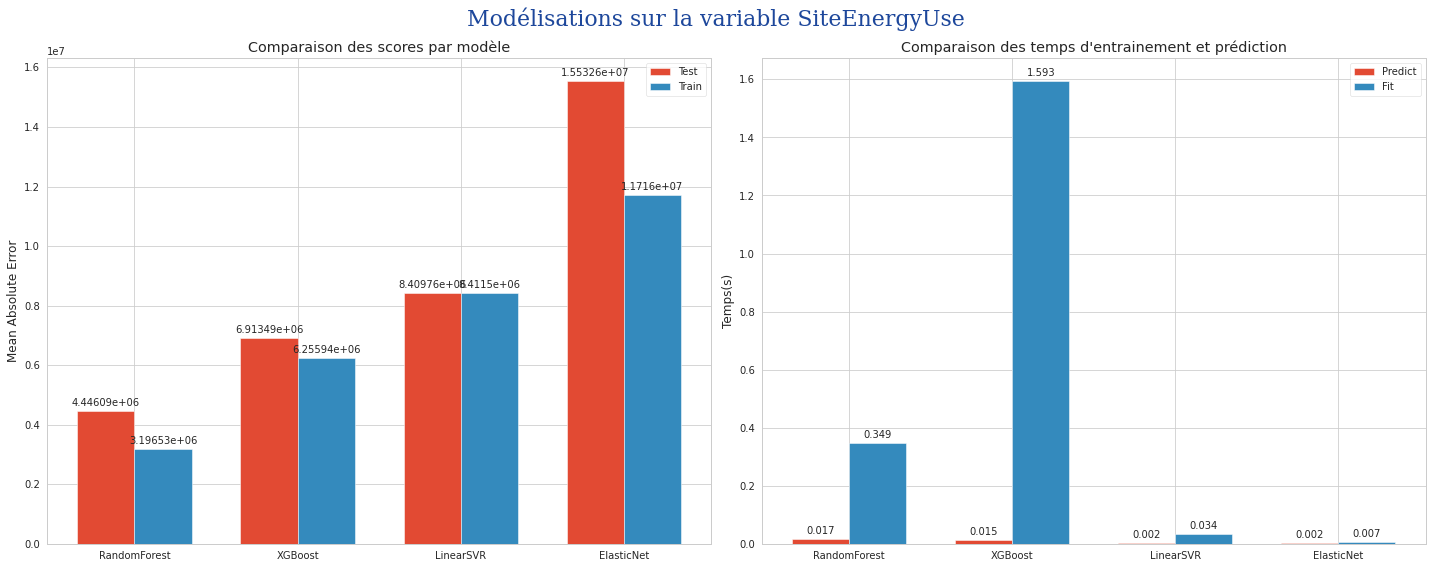

In [47]:
SEU_final_metrics_compare = SEU_final_metrics_compare[SEU_final_metrics_compare.index != 'LinearRegression']
x = np.arange(len(SEU_final_metrics_compare.index))
width = 0.35

fig, ax = plt.subplots(1,2,figsize=(20,8), sharey=False, sharex=False)

scores1 = ax[0].bar(x - width/2, -1*SEU_final_metrics_compare['mean_test_neg_mean_absolute_error'], width, label='Test')
scores2 = ax[0].bar(x + width/2, -1*SEU_final_metrics_compare['mean_train_neg_mean_absolute_error'], width, label='Train')
ax[0].set_ylabel('Mean Absolute Error')
ax[0].set_title('Comparaison des scores par modèle')
ax[0].set_xticks(x)
ax[0].set_xticklabels(SEU_final_metrics_compare.index)
ax[0].legend()
ax[0].bar_label(scores1, padding=3)
ax[0].bar_label(scores2, padding=3)

times1 = ax[1].bar(x - width/2, SEU_final_metrics_compare['mean_score_time'], width, label='Predict')
times2 = ax[1].bar(x + width/2, SEU_final_metrics_compare['mean_fit_time'], width, label='Fit')
ax[1].set_ylabel('Temps(s)')
ax[1].set_title("Comparaison des temps d'entrainement et prédiction")
ax[1].set_xticks(x)
ax[1].set_xticklabels(SEU_final_metrics_compare.index)
ax[1].legend()
ax[1].bar_label(times1, padding=3, fmt='%.3f')
ax[1].bar_label(times2, padding=3, fmt='%.3f')

plt.suptitle("Modélisations sur la variable SiteEnergyUse", fontdict=font_title, fontsize=22)
fig.tight_layout()

plt.show()

Pour la variable SiteEnergyUse, le modèle RandomForest offre à nouveau les meilleurs scores MAE et les meilleurs temps d'entrainement et de prédiction. **<font color="green">Nous allons donc séléctionner le modèle RandomForestRegressor pour prédire la variable SiteEnergyUse</font>**.

Regardons maintenant l'impact des hyperparamètres de la Grille de recherche :

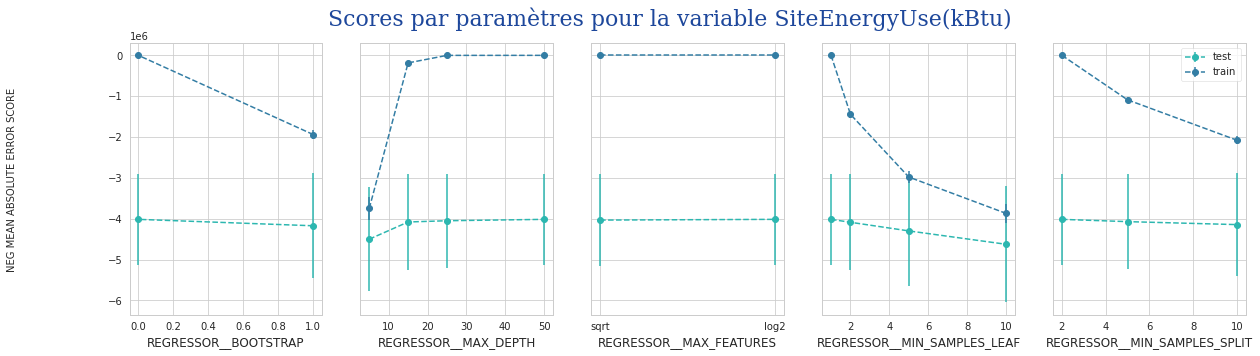


Rappel des meilleurs paramètres :
{'regressor__bootstrap': False, 'regressor__max_depth': 50, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}


In [48]:
plot_search_results(SEU_rfr_model.named_steps['grid_search_rfr'], title="SiteEnergyUse(kBtu)")

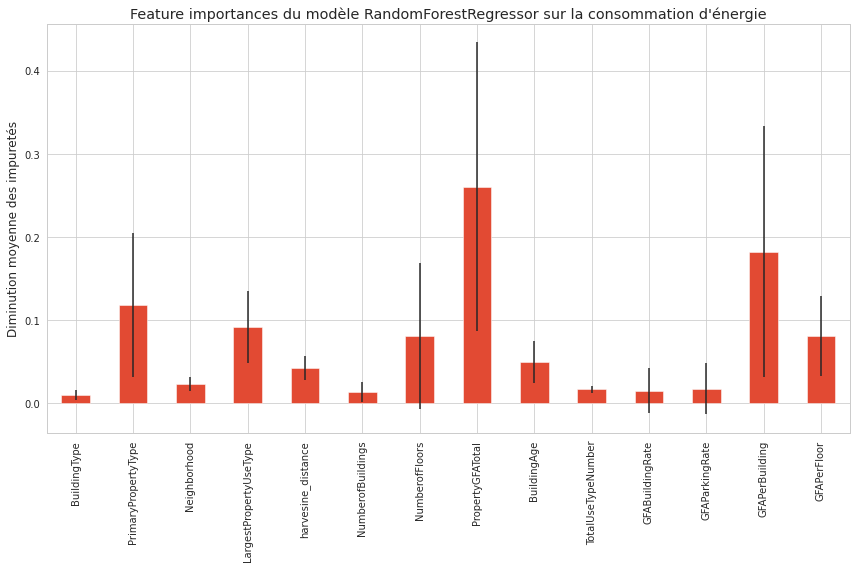

In [49]:
feature_importance = SEU_rfr_model.named_steps['grid_search_rfr'].best_estimator_.regressor_.feature_importances_ 
features_names = get_feature_names(SEU_rfr_model.named_steps['preprocessor'])
std = np.std([
    tree.feature_importances_ for tree in SEU_rfr_model.named_steps['grid_search_rfr'].best_estimator_.regressor_], axis=0)
df_feature_importance = pd.Series(feature_importance, index=features_names)

fig, ax = plt.subplots(figsize=(12,8))
df_feature_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances du modèle RandomForestRegressor sur la consommation d'énergie")
ax.set_ylabel("Diminution moyenne des impuretés")
fig.tight_layout()

Pour les consommations d'énergie, la surface de la propriété à ici également une importance bien supérieure aux autres variables.

## <font color="#337da4" id="section_6">6. Test des modèles sélectionnés</font>

Nous allons à présent tester les modèles sélectionnés sur nos données test et vérifier leurs performances.

### <font color="#2cb7b0" id="section_6_1">6.1. Prédiction des émissions de CO2</font>

In [50]:
def metrics_model(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    diff = y_true - y_pred
    mae = np.mean(abs(diff))
    r2 = 1-(sum(diff**2)/sum((y_true-np.mean(y_true))**2))
    dict_metrics = {"Métrique":["MAE", "R²"], "Résultats":[mae, r2]}
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics

In [51]:
def plot_pred_true(y_true, y_pred, color=None, title=None):
    X_plot = [y_true.min(), y_true.max()]
    fig = plt.figure(figsize=(12,8))
    plt.scatter(y_true, y_pred, color=color, alpha=.6)
    plt.plot(X_plot, X_plot, color='r')
    plt.xlabel("Valeurs réélles")
    plt.ylabel("Valeurs prédites")
    plt.title("Valeurs prédites VS valeurs réélles | Variable {}".format(title), 
              fontdict=font_title, fontsize=18)
    plt.show()

In [52]:
#Modèle avec les meilleurs paramètres pour les émissions de CO2

import time
start_time = time.time()

GHG_pred = GHG_rfr_model.predict(X_test)

print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time)))

Temps d'execution de l'agorithme : 0.029 s.


In [53]:
#Calcul des métriques pour les émissions de CO2
GHGmetrics = metrics_model(Y_test['TotalGHGEmissions'],GHG_pred)
GHGmetrics

,Métrique,Résultats
0,MAE,6.479678e+06
1,R²,-7.735023e+08


**Les métriques sur le jeu de données de test sont très dégradées comparativement aux métriques obtenues avec la GridSearch** avec le modèle de RandomForestRegressor. Nous allons vérifier la distribution des valaurs prédites en fonction des valeurs réélles :

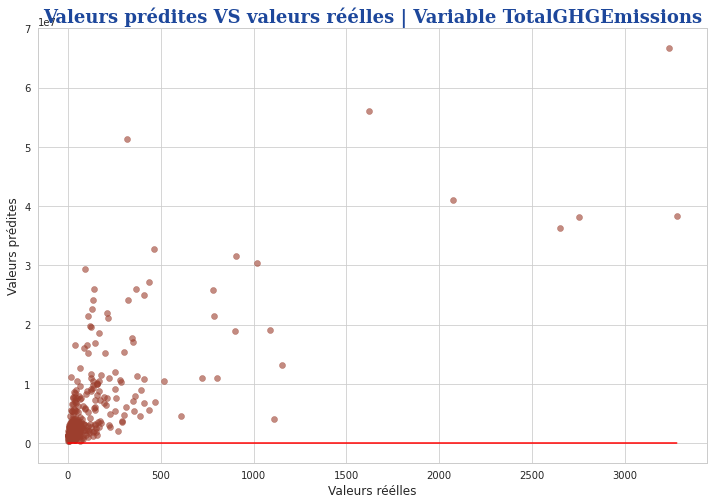

In [54]:
#Affichage des valeurs prédites vs valeurs réélles pour émissions de CO2
plot_pred_true(Y_test['TotalGHGEmissions'],GHG_pred, color="#9C3E2D", title="TotalGHGEmissions")

Les valeurs prédites sont très éloignées de la première bissectrice. En effet, **le transformer log() / exp() de notre variable Y emplifie les erreurs lors de la transformation inverse**.

Nous allons regarder les scores obtenus sur les différents splits de la Cross-validation pour vérifier les écarts :

In [55]:
GHG_test_results = GHG_rfr_results[['split0_test_neg_mean_absolute_error',
                'split1_test_neg_mean_absolute_error',
                'split2_test_neg_mean_absolute_error',
                'split3_test_neg_mean_absolute_error',
                'split4_test_neg_mean_absolute_error',
                ]][GHG_rfr_results['rank_test_neg_mean_absolute_error']==1].values
GHG_train_results = GHG_rfr_results[['split0_train_neg_mean_absolute_error',
                'split1_train_neg_mean_absolute_error',
                'split2_train_neg_mean_absolute_error',
                'split3_train_neg_mean_absolute_error',
                'split4_train_neg_mean_absolute_error',
                ]][GHG_rfr_results['rank_test_neg_mean_absolute_error']==1].values

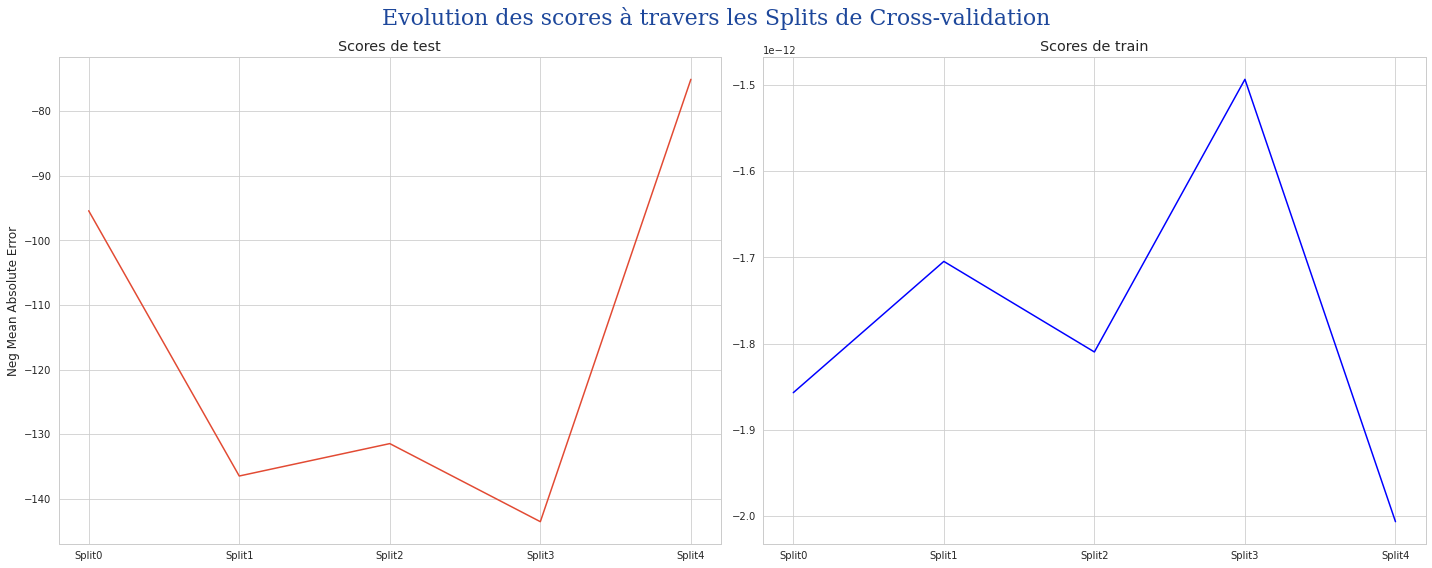

In [56]:
x = np.arange(0,5,1)
fig, ax = plt.subplots(1,2, figsize=(20,8), sharey=False, sharex=False)
ax[0].plot(range(0,5), GHG_test_results.reshape(-1))
ax[0].set_xticks(x)
ax[0].set_xticklabels(["Split"+str(n) for n in range(0,5)])
ax[0].set_ylabel('Neg Mean Absolute Error')
ax[0].set_title('Scores de test')

ax[1].plot(range(0,5), GHG_train_results.reshape(-1), color='b')
ax[1].set_xticks(x)
ax[1].set_xticklabels(["Split"+str(n) for n in range(0,5)])
ax[1].set_title('Scores de train')

plt.suptitle("Evolution des scores à travers les Splits de Cross-validation", fontdict=font_title, fontsize=22)
fig.tight_layout()

plt.show()

On voit ici que les scores des différents splits de cross-validation, pour les meilleurs paramètres obtenus, évoluent correctement lors de l'entrainement et des test, tout en restant dans la même échelle.

Les écarts et mauvais résultats obtenus dépendent donc du faible nombre de données qui impactent le Train_Test_Split initial. Le modèle est correctement entrainé mais n'obtient pas de bon résultats sur le jeu de test *(pas d'overfiting constaté dans les entrainements)*.

### <font color="#2cb7b0" id="section_6_2">6.2. Prédiction des consommations d'énergie</font>

In [57]:
start_time = time.time()

SEU_pred = SEU_rfr_model.predict(X_test)

print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time)))

Temps d'execution de l'agorithme : 0.032 s.


In [58]:
#Calcul des métriques pour les émissions de CO2
SEUmetrics = metrics_model(Y_test['SiteEnergyUse(kBtu)'],SEU_pred)
SEUmetrics

,Métrique,Résultats
0,MAE,3.380301e+06
1,R²,6.826791e-01


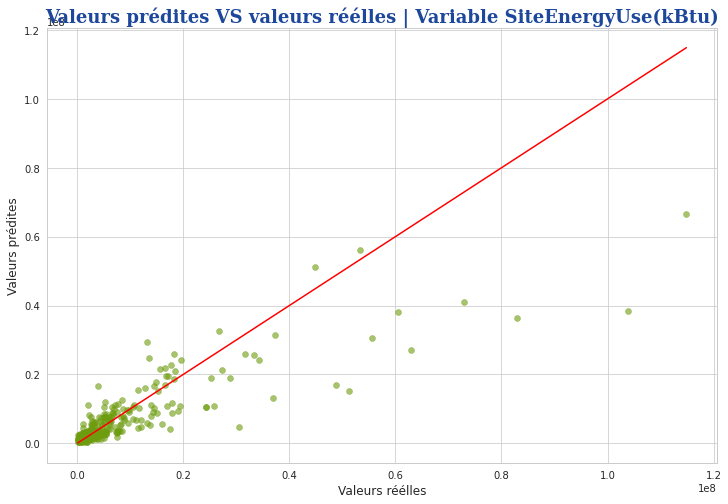

In [59]:
#Affichage des valeurs prédites vs valeurs réélles pour émissions de CO2
plot_pred_true(Y_test['SiteEnergyUse(kBtu)'],SEU_pred, color="#6D9C0E", title="SiteEnergyUse(kBtu)")

Ici encore, le même problème que pour la variable TotalGHG se pose. Le modèle est performant en entrainement mais ne parveint pas à généraliser sur le jeu de test.

Nous allons regarder les **écarts de prédiction en fonction du type de bâtiment** pour vérifier si des écarts sont plus importants dans certaines catégories :

In [60]:
final_SEU_test = pd.concat([X_test,Y_test],axis=1)
final_SEU_test['SEU_pred'] = SEU_pred
compare_final_SEU_test = final_SEU_test = final_SEU_test.groupby(by='BuildingType').mean()

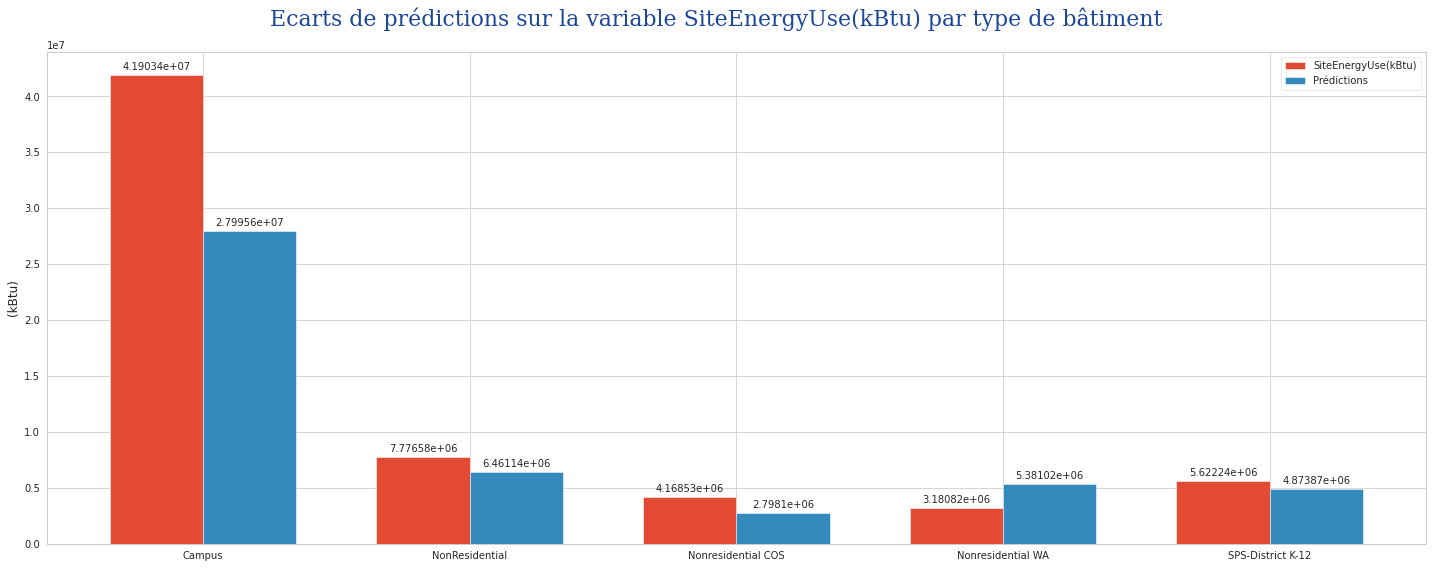

In [61]:
x = np.arange(len(compare_final_SEU_test.index))
width = 0.35

fig, ax = plt.subplots(figsize=(20,8), sharey=False, sharex=False)

scores1 = ax.bar(x - width/2, compare_final_SEU_test['SiteEnergyUse(kBtu)'], width, label='SiteEnergyUse(kBtu)')
scores2 = ax.bar(x + width/2, compare_final_SEU_test['SEU_pred'], width, label='Prédictions')
ax.set_ylabel('(kBtu)')
ax.set_xticks(x)
ax.set_xticklabels(compare_final_SEU_test.index)
ax.legend()
ax.bar_label(scores1, padding=3)
ax.bar_label(scores2, padding=3)

plt.suptitle("Ecarts de prédictions sur la variable SiteEnergyUse(kBtu) par type de bâtiment", fontdict=font_title, fontsize=22)
fig.tight_layout()

plt.show()

L'écart est très important sur la catégorie "Campus" qui est faiblement représentée dans le jeu de données mais qui présente les plus grandes consommations.

## <font color="#337da4" id="section_7">7. Influence du score ENERGY STAR</font>

Le score **ENERGY STAR** fournit un aperçu complet de la performance énergétique d'un bâtiment, en tenant compte des actifs physiques, des opérations et du comportement des occupants du bâtiment. Il est exprimé sur une échelle de 1 à 100 facile à comprendre : **plus le score est élevé, meilleure est la performance énergétique du bâtiment**.

Ce score permet de réaliser plusieurs actions :
- Évaluer les données énergétiques réelles facturées,  
- Normaliser pour l'activité commerciale *(heures, travailleurs, climat)*, 
- Comparer les bâtiments à la population nationale, 
- Indiquer le niveau de performance énergétique.

Nous allons donc évaluer si ce score à un impact significatif sur les performances de notre modélisation.

In [62]:
#Ajout de la variable à nos variables X
X['energystar_score'] = energystar_score
#Ajout de la variable dans les variables numérique du preprocessor
numeric_features.append('energystar_score')

In [63]:
#Filtrage des données ayant un Energy Star Score renseigné
X = X[X['energystar_score'].isnull()==False]
Y = Y[Y.index.isin(list(X.index))]

Regardons la distribution de cette variable ainsi que sa relation avec les émissions de CO2 :

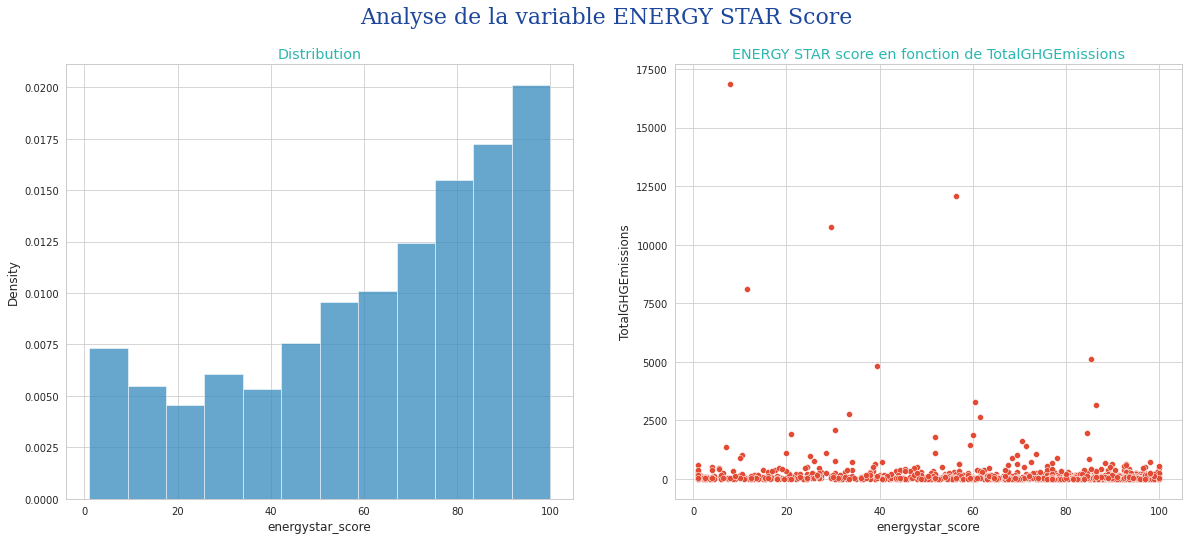

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=X, x='energystar_score', stat="density", ax=axes[0])
axes[0].set_title("Distribution", color='#2cb7b0')
sns.scatterplot(data=pd.concat([X,Y], axis=1), y='TotalGHGEmissions', x='energystar_score', ax=axes[1])
axes[1].set_title("ENERGY STAR score en fonction de TotalGHGEmissions", color='#2cb7b0')
plt.suptitle("Analyse de la variable ENERGY STAR Score", fontdict=font_title, fontsize=22)
plt.show()

On remarque ici que le score ENERGY STAR ne semble pas avoir de corrélation importante avec les émissions de CO2. La distribution ne suit pas de loi normale et la majorité des batiments a un score supérieur à 50 *(de bonne qualité voir de très bonne qualité)*.

In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 833 lignes,
Test: 209 lignes.



On utilise ici le meilleur modèle calculé sur la variable `TotalGHGEmissions` en incluant l'ENERGY STAR Score :

In [66]:
rfr_grid_cv_eStar = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr_eStar', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=RandomForestRegressor(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_rfr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

GHG_rfr_model_eStar = rfr_grid_cv_eStar.fit(X_train, Y_train['TotalGHGEmissions'])
GHG_rfr_results_eStar = model_scores(GHG_rfr_model_eStar, 'grid_search_rfr_eStar')

Meilleur score MAE : -111.121
Meilleur Score R2 : 0.385
Meilleurs paramètres : {'regressor__bootstrap': False, 'regressor__max_depth': 15, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5}
Temps moyen d'entrainement : 256.84s


In [67]:
GHG_pred_star = GHG_rfr_model_eStar.predict(X_test)
#Calcul des métriques pour les émissions de CO2
GHGmetricsES = metrics_model(Y_test['TotalGHGEmissions'],GHG_pred_star)
GHGmetrics = GHGmetrics.rename(columns={"Résultats" : "Sans ENERGY STAR"})
GHGmetrics['Avec ENERGY STAR'] = GHGmetricsES['Résultats']
GHGmetrics

,Métrique,Sans ENERGY STAR,Avec ENERGY STAR
0,MAE,6.479678e+06,152.413871
1,R²,-7.735023e+08,0.452492


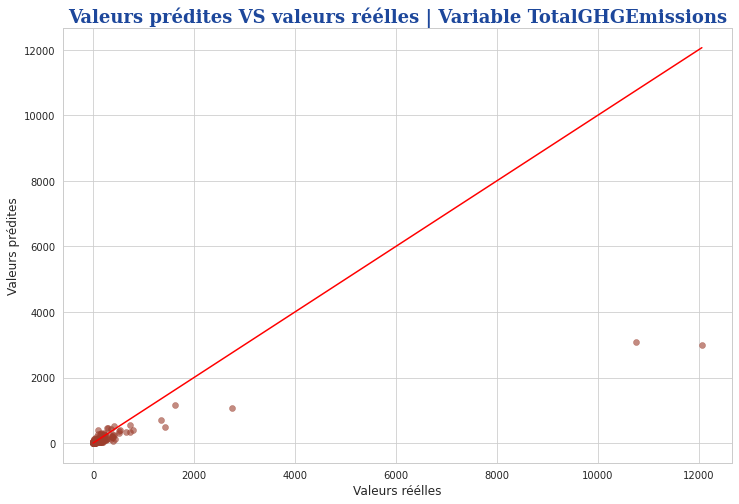

In [68]:
#Affichage des valeurs prédites vs valeurs réélles pour émissions de CO2
plot_pred_true(Y_test['TotalGHGEmissions'],GHG_pred_star, color="#9C3E2D", title="TotalGHGEmissions")

Les valeurs prédites sont en effet beaucoup plus reserrées sur la première bissectrice et **les métriques se sont améliorées grâce à la prise en compte de l'ENERGY STAR Score**. 

En revanche, cette variable est encore **peu renseignée et le jeu de données comporte peu d'entrées**. Il est donc difficile de savoir si cette amélioration est **rééllement significative**. Il faut également prendre en compte le bénéfice vis à vis du coût de cet ENERGY STAR Score.